<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span><ul class="toc-item"><li><span><a href="#DBS-with-Virtual-Permitivity" data-toc-modified-id="DBS-with-Virtual-Permitivity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>DBS with Virtual Permitivity</a></span></li><li><span><a href="#Enriched-FEM:-No-Virtual-Permitivity" data-toc-modified-id="Enriched-FEM:-No-Virtual-Permitivity-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Enriched FEM: No Virtual Permitivity</a></span></li></ul></li><li><span><a href="#Monitors" data-toc-modified-id="Monitors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monitors</a></span><ul class="toc-item"><li><span><a href="#Total-integrals" data-toc-modified-id="Total-integrals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Total integrals</a></span></li><li><span><a href="#Number-of-Degrees-of-Freedom" data-toc-modified-id="Number-of-Degrees-of-Freedom-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Number of Degrees of Freedom</a></span></li><li><span><a href="#Times" data-toc-modified-id="Times-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Times</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition, mark_inset)
from matplotlib.offsetbox import AnchoredText

import numpy as np
from dolfin import *
from multiphenics import *

# Intro
We model a voltage-controlled stimulation with Medtronic 3387 electrode in 2D. The first (C0) and third (C2) are kept at the fixed (dimensionless) voltage of 1 and 0, repectively. The domain, representing the brain, is confined to a cylindrical box with a physical diameter and height of 4 cm. To ensure uniqueness of the solution, the bottom edge is set at a potential of 0, playing the role of the ground. A non-dispersive and isotropic tissue is considered. 

**Note**: These simplifications are done to isolate the inferiority of virtual permitivity (VP) appraoch compared to the extended finite element method (eFEM).

We use `fenics/dolfin` and `multiphenics` for FEM calclulations.

In [2]:
import dolfin # just for printing the version

print(matplotlib.__version__)
print(np.__version__)
print(dolfin.__version__)

3.0.3
1.19.5
2019.2.0.dev0


In [3]:
# some global parameters
tol = DOLFIN_EPS
degree = 2    # degree of Lagrange finite elements
sigma0 = 1    # tissue conductivity (unitless)
z = 1e-2      # electrode-tissue impedance (unitless)
N = 4         # number of contacts on the electrode
f0 = 1e-15    # a zero forcing (optional - added for stability)

In [4]:
# these functions are used for time profiling
def solve_vp(a,b,u,bcs):
    A = assemble(a)
    B = assemble(b)
    for bc in bcs:
        bc.apply(A)
        bc.apply(B)
    solve(A, u.vector(), B)
    return u

def solve_efem(a,b,U, bcs):
    A = block_assemble(a)
    B = block_assemble(b)
    bcs.apply(A)
    bcs.apply(B)
    block_solve(A, U.block_vector(), B)
    return U


def plot_mesh(mesh, mesh_name, save=True):
    """
    This function plots meshes nicely.
    """
    # mesh-related values to color the mesh plots
    L = 0.02; 
    R = 0.00127/2; 
    l = 0.0015; 
    gap = l; 
    y_start = gap-R;  

    right_x= [L,-L]
    right_y= [L, L]
    left_x= [-L,-L]
    left_y= [-L, L]
    bottom_x=[-L,L] 
    bottom_y=[-L,-L]
    top_x1 = [-L,-R]
    top_x2 = [R,L]
    top_y = [L,L]

    D_xl = [-R,-R]
    D_xr = [R,R]
    D1_y = [y_start, y_start+l]
    D2_y = [y_start+ 2*(gap+l), y_start+ 2*(gap+l)+l]

    fp1_y = [y_start+ (gap+l), y_start+ (gap+l)+l]
    fp2_y = [y_start+3*(gap+l), y_start+ 3*(gap+l)+l]
    
    
    plot(mesh, linewidth=.15,)
    plt.plot(bottom_x, bottom_y, color='g', label=r'$\phi$=0') 
    plt.plot(D_xl, D1_y, color='b')
    plt.plot(D_xr, D1_y, color='b', label=r'$\phi$=1')
    plt.plot(D_xl, D2_y, color='r')
    plt.plot(D_xr, D2_y, color='r', label=r'$\phi$=0')
    plt.plot(D_xl, fp1_y, ':', color='orange')
    plt.plot(D_xr, fp1_y, ':', color='orange')
    plt.plot(D_xl, fp2_y, ':', color='orange')
    plt.plot(D_xr, fp2_y, ':', color='orange', label='Floating')

    plt.legend(loc='upper left')

    ax_ = plt.gca()
    ax = plt.axes([0.81,0.05,0.15,0.9])
    ip = InsetPosition(ax, [0, 0, 1, 1])

    plot(mesh, linewidth=.2)
    plt.plot(bottom_x, bottom_y, color='g') # dirichlet
    plt.plot(D_xl, D1_y, color='b')
    plt.plot(D_xr, D1_y, color='b')
    plt.plot(D_xl, D2_y, color='r')
    plt.plot(D_xr, D2_y, color='r')
    plt.plot(D_xl, fp1_y, ':', color='orange')
    plt.plot(D_xr, fp1_y, ':', color='orange')
    plt.plot(D_xl, fp2_y, ':', color='orange')
    plt.plot(D_xr, fp2_y, ':', color='orange')

    ax.set_axes_locator(ip)
    x1, x2, y1, y2 = 2e-4, 1e-3, 5e-4, 7.5e-3
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    mark_inset(ax_, ax,loc1=3, loc2=2 , fc="none", ec='0.5')

    for a in [ax, ax_]:
        a.set_xticklabels([])
        a.set_yticklabels([])

    plt.tight_layout()
    
    if save:
        plt.savefig('./results/'+mesh_name+'.png', dpi=300, bbox_inches='tight')

# Mathematical Formuloation
We consider two different formulations:
- Enriched Finite Element Method (eFEM)
- Virtual Permitivity

eFEM is what we propose as the next generation of volume condution implementation. It has several important features which are desireable for accurate VCM which is critical for patient-specific in-silico models, namely it 
- forces constant voltage on contact surfaces, bu desige
- incorporates the surface impedance of the interface
- has no free (computational) parameter
- is scalable to hundreds of contacts very easily
- is capable of hybrid stimulation (current-voltage)
- computes the value of all floating potentials in one go
- doesn't purturb solvability of the problem

These are achieved by introducing additional solution spaces and augmenting to the normal finite element space with them. In simplt terms, instead of only finding the potential voltage on a region of interest in the brain, we simultaneously find the potential values on the contacts as well. So the full solution would be $(u,U)$ with $u\in V = H(\Omega)_D^1$ and $U\in R^N$ with $N$ being the total number of contacts whose potential is unknown. The total mixed finite element is thus, $W = V \oplus R^N$.

We solve the following weak formulation

$$\int_\Omega \sigma \nabla u \cdot \nabla v + \sum_{i=1}^N \int_{\partial \Omega_i} \frac{(u-U_i)(v-V_i)}{z_i} + \sum_{j=1}^{N_V} \int_{\partial \Omega_j}\frac{uv}{z_j}= \int_\Omega fv + \sum_{i=1}^N I_iV_i + \sum_{j=1}^{N_V} \int_{\partial \Omega_j}\frac{\phi_j v}{z_j}$$

In which $u$ ($v$) and $U_i$ ($V_i$) are the trial and test functions, respectively. $\partial_oemga_i$ goes over all boundaries with active or passive current injection (whose potential is unknown). Passive contacts are simply modeled by $I=0$. $\partial \Omega_j$ goes over electrode contacts whose value potential is fixed to $\phi_j$. $z_i$ and $z_j$ specify the surface impendaces of each contact. 

>**Note**: One has to differentiate between the *tissue*'s potential on the contact surface, and the ones of *electroede*. They would be the same, if there was no interface between them. But in reality, this is not the case. A consequence of it is that the potential of tissue near the surface of the contact **can be non-uniform** even though the electrode's potential is a (uniform) constant all over the surface. As a result, the current density can't be uniform, and standard Neumann coniditon doesn't apply here.

## Enriched FEM

In [5]:
# Mesh selection
mesh_name = 'DBS'
path = './meshes/'+mesh_name+'/'
mesh = Mesh(path+mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, path+mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, path+mesh_name+"_facet_region.xml")
cnt_id = 25 # this is the id of first contact in the mesh

## uncomment the following lines if you want to view in Paraview
# File(path+mesh_name+"_boundaries.pvd") << boundaries
# File(path+mesh_name+"_subdomains.pvd") << subdomains

Let's have a look at the mesh prepared for eFEM. Note that the $phi$s are potentials on the contacts. Due to the interface resistance, the voltage in tissue would be different. Note that the potentials are added on colored surfaces (blue/red).

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


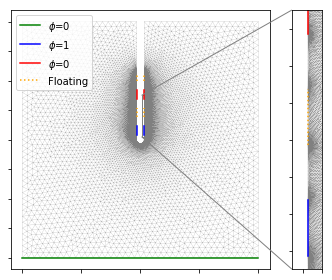

In [6]:
plot_mesh(mesh, mesh_name)

In [7]:
# function space def.
V = FunctionSpace(mesh, "Lagrange", degree)
R = FunctionSpace(mesh, "R", 0)       
W = BlockFunctionSpace([V]+[R]*N)   
dof_fem = V.dim()   # degrees of freedom on the domain
dof_efem = W.dim()  # degrees of freedom of the mixed space (=dof_fem+4)

x = SpatialCoordinate(mesh)
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

# we need the area of each contact on the weak form
areas = [assemble(2*pi*x[0]*dot(n,n)*ds(cnt_id+i)) for i in range(N)] 

sigma = sigma0 # conductivity constant 

# forcing
f= Constant(f0)

Let's parse what have we done so far. We defined a function space $V$ (second order Lagrange polynomial) over which the solution (potential of the tissue) will be defined. In addition to that, we have defined $N$ extra real values. By now we know that they represent the potential value on the surface of the electrode. The fact that these value are **constant** for each contact clearly shows that, by design, we have forced the constant potential on the electrode surface. 

>**Note**: One has to differentiate between the *tissue*'s potential on the contact surface, and the ones of *electroede*. They would be the same, if there was no interface between them. But in reality, this is not the case. A consequence of it is that the potential of tissue near the surface of the contact **can be non-uniform** even though the electrode's potential is a (uniform) constant all over the surface. As a result, the current density can't be uniform, and standard Neumann coniditon doesn't apply here.

To better handle to sums in the weak form, we specify the types of input for each contact. By default, we assume all contacts are passive current-controlled contacts. We change them later on to reflect the BCs.

## Boundary conditions
In our problem, we would investigate a scenario in which C0 and C2 are under voltage-controlled stimulation. Thus we have to change thier input type as well as their value. In addition we set the lower edge as zero potential.

>**Note**: This extra grounding on the bottom isn't necessary as the problem has unique solution due to the boudary condition. But to supress `multiphenics` objections regarding lack of Dirichlet BCs, we enforce it at teh moment. It won't have much impact on our analysis.

In [8]:
# We need to specify the type of input for the weak form
input_types = ['I' for i in range(N)]
inputs = [Constant(0) for i in range(N)] 

# fixed potential on C0 and C2
input_types[0]='V'
input_types[2]='V'
inputs[0] = Constant(1)
inputs[2] = Constant(0)

# the exterior boundary conditions are easy.
bc_bottom = DirichletBC(W.sub(0), Constant(0), boundaries, 3) # bottom

# this makes a block BCs object (note the emptyness of the contacts' block)
bcs = BlockDirichletBC([[ bc_bottom ]]+ 
                       [[], [], [], []])

To decrease the computational cost, we work on a 2D section. Due to the axisymmetry, we can simply multiply the weak form by the determinant of Jacobian of the transformation from xz to the cylindrical coordiantes: $2\pi r$. The following cell just makes both sides of the weak form.

In [9]:
# WEAK FORM
# define the mixed elements
u_mix = BlockTrialFunction(W)
v_mix = BlockTestFunction(W)

# split the mixed elemetns
u_spl = block_split(u_mix)
v_spl = block_split(v_mix)

# RHS
a_00 = 2*pi*x[0]*inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
a_0n = []
a_n0 = []
a_nn = []
for i in range(N):
    a_00 += 2*pi*x[0]*dot(u_spl[0],v_spl[0])/z*ds(cnt_id+i)
    if input_types[i]=='I':
        a_0n.append(-2*pi*x[0]*dot(u_spl[0], v_spl[i+1])/z*ds(cnt_id+i))
        a_n0.append(-2*pi*x[0]*dot(u_spl[i+1], v_spl[0])/z*ds(cnt_id+i))
        a_nn.append(+2*pi*x[0]*dot(u_spl[i+1], v_spl[i+1])/z*ds(cnt_id+i))
    else:
        a_0n.append(0)
        a_n0.append(0)
        a_nn.append(0)
    
a = np.zeros((N+1,N+1), dtype=type(a_00))
np.fill_diagonal(a, [a_00]+ a_nn)
a[0,1:] = a_n0
a[1:,0] = a_0n
a = a.tolist()

# LHS
b0 = [ 2*pi*x[0]*f*v_spl[0]*dx ] 
bn = []
for i in range(N):
    if input_types[i]=='I':
        bn.append(2*pi*x[0]*inputs[i]*v_spl[i+1]/areas[i]*ds(cnt_id+i))
    else:
        bn.append(2*pi*x[0]*inputs[i]*v_spl[0]/z*ds(cnt_id+i))
b = b0 + bn

>**An implementaitonal side note**: We set $N$ equal to the total number of contacts on the electrodes. This is goes against our notaiton above. It is just a lazy way of coding, which leads to `nan` values for floating potentials whose value is prescribed. Nothing important, but better to remember....  

In [10]:
monitor_efem = dict(times = [],  # runtime
                   Us = [],      # solution
                   I_0 = [],     # current into contact C0
                   I_2 = [],     # current from contact C2
                   I_left = [],  # current passing from left edge (must be zero)
                   I_right=[],   # current passing from left edge (must be zero)
                   I_bottom = [] # current passing from the bottom edge
                  )


# again we solve it once to make sure FCC doesn't harm us
U = BlockFunction(W)
u = solve_efem(a,b,U,bcs)
monitor_efem['Us'].append(u[0])

time = %timeit -o solve_efem(a,b,U,bcs)
monitor_efem['times'].append(time)
    
# post-processing: currents
monitor_efem['I_0'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u[0]),n)*ds(cnt_id+0))))
monitor_efem['I_2'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u[0]),n)*ds(cnt_id+2))))
monitor_efem['I_left'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u[0]),n)*ds(1))))
monitor_efem['I_right'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u[0]),n)*ds(2))))
monitor_efem['I_bottom'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u[0]),n)*ds(3))))

1 loop, best of 3: 1.12 s per loop


## Virtual Permitivity

In [11]:
# Mesh selection
mesh_name = 'DBS_VP'
path = './meshes/'+mesh_name+'/'
mesh = Mesh(path+mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, path+mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, path+mesh_name+"_facet_region.xml")
cnt_id = 33 # this is the id of first contact in the mesh

## uncomment the following lines if you want to view in Paraview
# File(path+mesh_name+"_boundaries.pvd") << boundaries
# File(path+mesh_name+"_subdomains.pvd") << subdomains

Lets have a look at the mesh. Note the "filled" areas which are VP's trick to model floating potentials. Unfortunately, it adds extra volume to the model. Expensive!

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


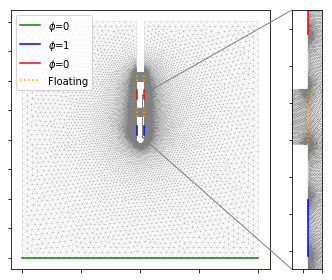

In [12]:
plot_mesh(mesh, mesh_name)

Those areas which are additionally defined, have a higher conductivity. This means that the conductivity is not a constant anymore, but a function of location. Here we handle it by defining the boolean variable `sig_chooser` which determines whether a location is within the virtual volumes or not.

In [13]:
# function space def.
V0 = FunctionSpace(mesh, 'DG', 0)
V = FunctionSpace(mesh, 'P', degree)
dof_vp = V.dim()   # total number of degrees of freedom

x = SpatialCoordinate(mesh)
dx = Measure('dx', domain=mesh, subdomain_data= subdomains)
ds = Measure('ds', domain=mesh, subdomain_data= boundaries)
n = FacetNormal(mesh)

# In VP two subdomins exist with different conductivity:
# - tissue (conductivity = sigma0)
# - metal (conductivity = k*sigma0)
sigma = Function(V0) # Virtual permitivity function
sig_chooser = np.asarray(subdomains.array()-1, dtype=np.int32)

# forcing
f= Constant(f0)

## Bondary conditions
To have a fair comparison between VP and eFEM, we have to be careful about the BCs. We know that the eFEM incorporates the surface impedance which induces a (non-uniform) voltage drop upon entring the domain from the surface of electrode. As VP only captures the tissue's voltage, a fair set of boundary coniditons would be those that match the already attenuated voltages of eFEM. We thus, interpolate the eFEM solution and set the Diriclet BCs on C0 and C2 according to the interpolant.

In [14]:
u = Function(V) # this stores an interpolation of eFEM solution 
LagrangeInterpolator.interpolate(u, monitor_efem['Us'][0])

# BCs
bc0 = DirichletBC(V, u, boundaries, cnt_id+0)  # C0
bc1 = DirichletBC(V, u, boundaries, cnt_id+2)  # C2
bc_bottom = DirichletBC(V, u, boundaries, 3)  # ground (bottom)
bcs = [bc0,bc1, bc_bottom]

Weak formulation for VP is very  easily made. But it's depends on the value of sigma. Note how it is redefined for every $k$.

In [15]:
ks = np.logspace(0,16,17,endpoint=True) # sweep the conductivity ratios

monitor = dict(times = [],   # runtime
               Us = [],      # solution
               I_0 = [],     # current into contact C0
               I_2 = [],     # current from contact C2
               I_left = [],  # current passing from left edge (must be zero)
               I_right=[],   # current passing from left edge (must be zero)
               I_bottom = [] # current passing from the bottom edge
              )

for k in ks:
    # WEAK FORM
    sigma.vector()[:] = np.choose(sig_chooser.astype(bool), [sigma0,k*sigma0])
    u = TrialFunction(V)
    v = TestFunction(V)

    # Note: 1, 3, and 5 are domain, volume in C1 and C3 respectively 
    a = 2*pi*x[0]* inner(sigma*grad(u), grad(v))*(dx(1)+dx(3)+dx(5))
    b = 2*pi*x[0]* f*v*(dx(1)+dx(3)+dx(5))
    u = Function(V)
    
    # we need to solve it once to ensure FFC of fenics wont effect times
    u = solve_vp(a,b,u,bcs)
    monitor['Us'].append(u)
    
    # now we perform time profiling
    time = %timeit -o solve_vp(a,b,u,bcs)
    monitor['times'].append(time)
    
    # post-processing: currents
    monitor['I_0'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+0))))
    monitor['I_2'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(cnt_id+2))))
    monitor['I_left'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(1))))
    monitor['I_right'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(2))))
    monitor['I_bottom'].append(abs(assemble(2*pi*x[0]*sigma*dot(grad(u),n)*ds(3))))

1 loop, best of 3: 1.06 s per loop
1 loop, best of 3: 1.06 s per loop
1 loop, best of 3: 1.06 s per loop
1 loop, best of 3: 1.05 s per loop
1 loop, best of 3: 1.05 s per loop
1 loop, best of 3: 1.08 s per loop
1 loop, best of 3: 1.09 s per loop
1 loop, best of 3: 1.08 s per loop
1 loop, best of 3: 1.09 s per loop
1 loop, best of 3: 1.13 s per loop
1 loop, best of 3: 1.15 s per loop
1 loop, best of 3: 1.16 s per loop
1 loop, best of 3: 1.1 s per loop
1 loop, best of 3: 1.08 s per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.07 s per loop
1 loop, best of 3: 1.07 s per loop


# Monitoring
Note let's compare them. by investigating the values we saved on `monitor` variables. But let's first ensure colors are normalized properly for all graphs.

In [16]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0, vmax=monitor_efem['Us'][0].vector()[:].max()) # the ensure 

### eFEM voltage distribution

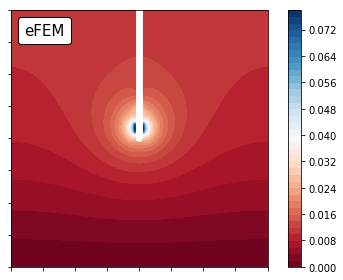

In [17]:
m=plot(monitor_efem['Us'][0],cmap='RdBu')
cbar = plt.colorbar(m)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
at = AnchoredText('eFEM',
                  prop=dict(size=15), frameon=True,
                  loc='upper left',
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
plt.tight_layout()
plt.savefig('./results/eFEM.png', dpi=300,
            bbox_inches='tight')

### VP voltage distribution

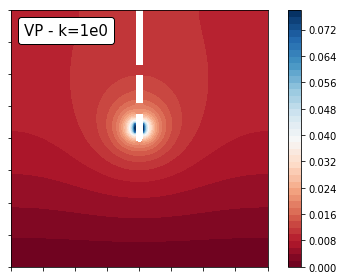

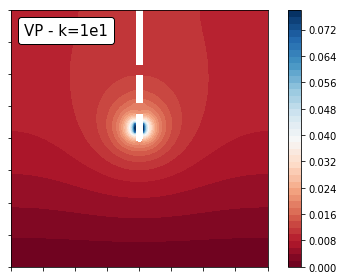

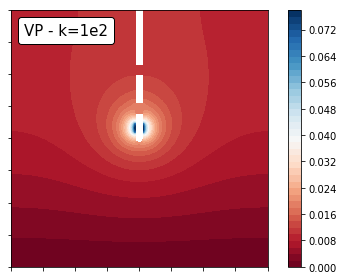

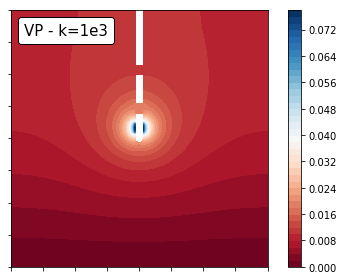

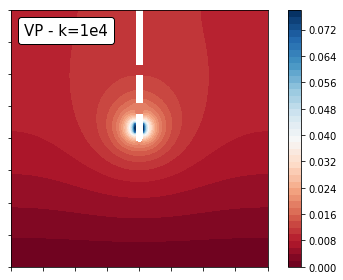

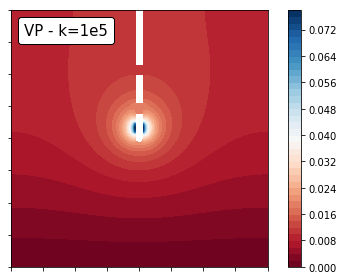

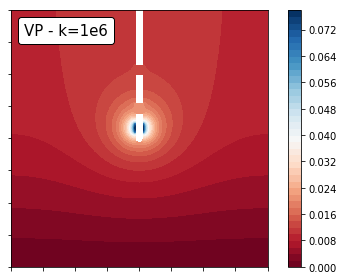

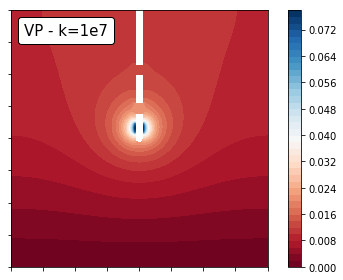

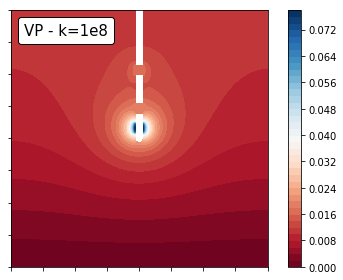

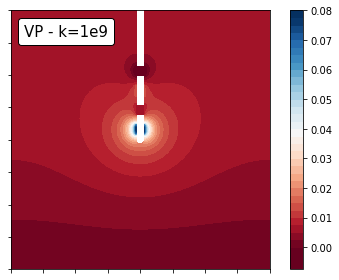

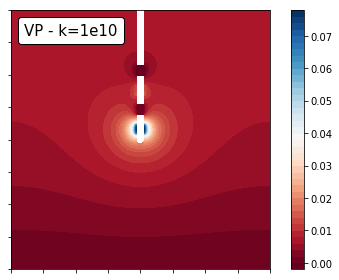

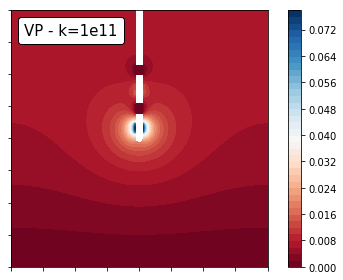

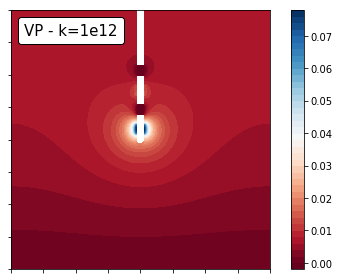

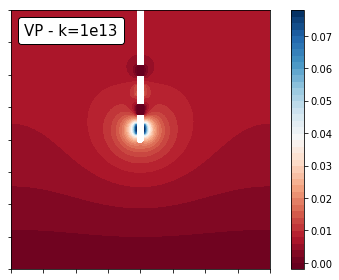

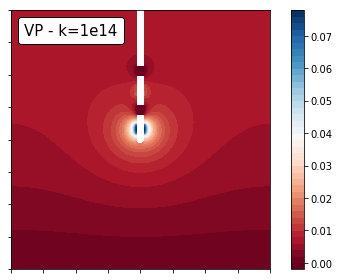

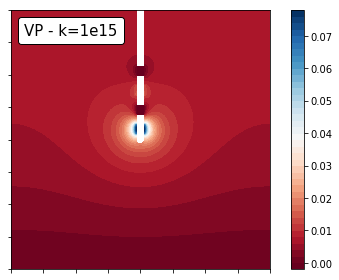

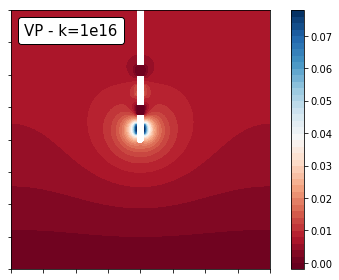

<Figure size 432x288 with 0 Axes>

In [18]:
for i, k in enumerate(ks):
    m = plot(monitor['Us'][i], cmap='RdBu', norm=norm)
    cbar = plt.colorbar(m)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    at = AnchoredText('VP - k=1e'+str(int(np.log10(k))),
                  prop=dict(size=15), frameon=True,
                  loc='upper left',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    plt.tight_layout()
    plt.savefig('./results/k'+str(int(np.log10(k)))+'.png', dpi=300,
                bbox_inches='tight')
    plt.show()
    plt.clf() # needed since we don't want to plot over the previous fig

It seems that the VP matches the actual solution until some particular $k$.

### difference in voltage distributions
We will look at the energy norm of the relative error: 
$$\sqrt{\frac{||u_{eFEM} - u_{VP}||^2}{||\max u_{eFEM}||^2}}$$

It's obvious the VPs solution is defined on a different mesh. So first we have to project it the the mesh of eFEM before we can compare them togeher.

In [19]:
# we need to interpolate VP solution on eFem mesh
mesh_efem = Mesh('meshes/DBS/DBS.xml')
V_efem = FunctionSpace(mesh_efem, "Lagrange", degree+1)
u_efem = monitor_efem['Us'][0]

for i, k in enumerate(ks):
    u_vp = monitor['Us'][i]
    
    # interpolating both on efem mesh
    u_vp_int = Function(V_efem)
    u_efem_int = Function(V_efem)
    
    # for some reason, Fenics complains about comparing 
    # the u_vp_interpolant and u_vp. I cound't find out
    # why. So I just make an interpolation of u_efem 
    # as well on the same mesh. Note that both of these
    # results are polynomals of degree 2 on each element
    # so an interpolation of degree>=2 certainly matches
    # the actual solution and we are not introducing 
    # trunctation error or whatsoever.
    LagrangeInterpolator.interpolate(u_vp_int, u_vp)
    LagrangeInterpolator.interpolate(u_efem_int, u_efem)

    # computing the relative error
    rel_diff = (u_vp_int-u_efem_int)/abs(u_efem.vector()[:].max())
    m = plot(sqrt(rel_diff**2)) # and plot the energy norm
    cbar = plt.colorbar(m)
    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    at = AnchoredText('VP - k=1e'+str(int(np.log10(k))),
                  prop=dict(size=15), frameon=True,
                  loc='upper left',
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    plt.title('Energy norm of (max-normalized) difference')
    plt.tight_layout()
    plt.savefig('./results/diff_k'+str(int(np.log10(k)))+'.png', dpi=300,
                bbox_inches='tight')
    plt.clf()

<Figure size 432x288 with 0 Axes>

## Total integrals
It both eFEM and VP give rise to the same solution, the integrated currents passing through surfaces must be the same, right? Let's see if that's the case...

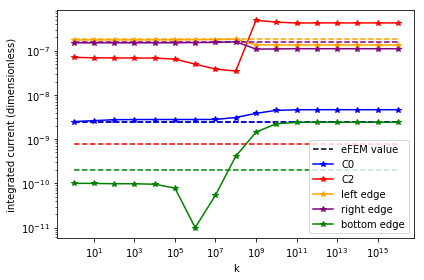

In [20]:
colors = ['b','r','orange','purple','g']

plt.plot([ks[0], ks[-1]], [monitor_efem['I_0']]*2, color= 'k', linestyle='--', label='eFEM value')
for i, name in enumerate(['0','2','left','right','bottom']):
    if name in ['0','2']:
        label = 'C'+name
    else:
        label = name+' edge'
    plt.plot(ks, monitor['I_'+name], label=label, marker='*', color= colors[i])
    plt.plot([ks[0], ks[-1]], [monitor_efem['I_'+name]]*2, color= colors[i], linestyle='--')

# plt.axvspan(1e6, 1e8, color='k', alpha=0.2, lw=0)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')#, bbox_to_anchor=(0.47, 0., 0.5, 0.5), ncol=2)
plt.xlabel('k')
plt.ylabel('integrated current (dimensionless)')
plt.tight_layout()
plt.savefig('./results/currents.png', dpi=300, bbox_inches='tight')

Which also certfies what we saw before in difference  plots. After $k=10^7$, the system becomes so ill-conditioned that the solutions do not match well anymore. 

## Number of Degrees of Freedom 
We can clearly see which method is introducing more dof:

In [21]:
print('VP: \t Total DoFs: {} \t\t Extra Dofs for subdomains: {}'.format(dof_vp, dof_vp-dof_fem))
print('eFEM:\t Total DoFs: {} \t\t Extra Dofs for FPs: {}'.format(dof_efem, dof_efem-dof_fem))

VP: 	 Total DoFs: 112509 		 Extra Dofs for subdomains: 17430
eFEM:	 Total DoFs: 95083 		 Extra Dofs for FPs: 4


In [22]:
dof_fem, dof_vp

(95079, 112509)

In [23]:
print('VP: \t Total DoFs: {} \t\t Extra Dofs for subdomains: {}'.format(dof_vp, dof_vp-dof_fem))
print('eFEM:\t Total DoFs: {} \t\t Extra Dofs for FPs: {}'.format(dof_efem, dof_efem-dof_fem))

VP: 	 Total DoFs: 112509 		 Extra Dofs for subdomains: 17430
eFEM:	 Total DoFs: 95083 		 Extra Dofs for FPs: 4


## Times
In our toy problem, we cannot see any boost in runtime. On the contrary, it seems the overload of `multiphenics` had overshadowed the difference in system sizes. However, recall that we were working on 2D, an in a very simplisitic setting. In real-world scenario, this would not be the case. Also, note that we could have used preconditioning for our symmetric block matrix, which we didn't. In fact, both methods, were computed with Fenics'es default solver ([Sparse LU decomposition](https://hplgit.github.io/fenics-tutorial/pub/sphinx1/._ftut1006.html)), which is efficient for thousands of degress of freedom (as in our case).

In [24]:
# eFEM
[time.best for time in monitor_efem['times']]

[1.1214197259396315]

In [25]:
# VP
for k,time in zip(ks,list(monitor['times'])):
    print('runtime at k={:.0e}:\t{}'.format(k, time.best))

runtime at k=1e+00:	1.0578950643539429
runtime at k=1e+01:	1.055214081890881
runtime at k=1e+02:	1.0564279584214091
runtime at k=1e+03:	1.0501582780852914
runtime at k=1e+04:	1.0487660188227892
runtime at k=1e+05:	1.0839741881936789
runtime at k=1e+06:	1.0899127991870046
runtime at k=1e+07:	1.0818545054644346
runtime at k=1e+08:	1.0910713812336326
runtime at k=1e+09:	1.1293411245569587
runtime at k=1e+10:	1.1474423315376043
runtime at k=1e+11:	1.1616831114515662
runtime at k=1e+12:	1.0974850663915277
runtime at k=1e+13:	1.0807654289528728
runtime at k=1e+14:	1.0748547250404954
runtime at k=1e+15:	1.0741542810574174
runtime at k=1e+16:	1.0698551088571548
